In [1]:
from SimPEG import *
# import sys
# sys.path.append("./simpegdc/")
import simpegDCIP as DC

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

try:
    from ipywidgets import interact, IntSlider, FloatSlider, FloatText, ToggleButtons
    pass
except Exception, e:
    from IPython.html.widgets import  interact, IntSlider, FloatSlider, FloatText, ToggleButtons
    
%matplotlib inline

In [2]:
npad = 4
cs = 2.
hx = [(cs,npad, -1.3),(cs,50),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,25)]
mesh = Mesh.TensorMesh([hx, hy], "CN")

In [3]:
def get_Layer_Potentials(rho1,rho2,h,A,B,xyz,infty=20):
#     xyz = Utils.ndgrid(x,y,z)
    k = (rho2-rho1) / (rho2+rho1)
    
    eps = 1e-6 #to stabilize division
    r = lambda src_loc: np.sqrt((xyz[:,0] - src_loc[0])**2 + (xyz[:,1] - src_loc[1])**2 + (xyz[:,2] - src_loc[2])**2)+eps

    m = Utils.mkvc(np.arange(1,infty+1))
    sum_term = lambda r: np.sum(((k**m.T)*np.ones_like(Utils.mkvc(r,2))) / np.sqrt(1. + (2.*h*m.T/Utils.mkvc(r,2))**2),1)
    
    V = lambda I,src_loc: (I*rho1 / (2.*np.pi*r(src_loc))) * (1 + 2*sum_term(r(src_loc)))
    
    VA = V(1.,A)
    VB = V(-1.,B)
    
    return VA+VB

In [4]:
h = 5.
rhomin = 1e2
rhomax = 1e3
cs = 1.
hx = [(cs,80+1)]
hy = [(cs,40)]
mesh_layers = Mesh.TensorMesh([hx, hy], "CN")
M,N = -10.,10.

 
G = lambda A, B, M, N: 1. / ( 1./np.abs(A-M) - 1./np.abs(M-B) - 1./np.abs(N-A) + 1./np.abs(N-B) )
rho_a = lambda VM,VN, A,B,M,N: (VM-VN)*2.*np.pi*G(A,B,M,N)

In [23]:
def plot_Layer_Potentials(rho1,rho2,h,A,B,M,N,imgplt='model'):
    
    ylim = np.r_[-1., 1.]*rhomax/(4*2*np.pi)

    fig, ax = plt.subplots(2,1,figsize=(9,7))

    fig.subplots_adjust(right=0.8)
    x = np.linspace(-40.,40.,200)
    z = np.linspace(x.min(),0,100)
    
    pltgrid = Utils.ndgrid(x,z)
    xplt = pltgrid[:,0].reshape(x.size,z.size,order='F')
    zplt = pltgrid[:,1].reshape(x.size,z.size,order='F')

    V = get_Layer_Potentials(rho1,rho2,h,np.r_[A,0.,0.],np.r_[B,0.,0.],Utils.ndgrid(x,np.r_[0.],np.r_[0.]))
    VM = get_Layer_Potentials(rho1,rho2,h,np.r_[A,0.,0.],np.r_[B,0.,0.],Utils.mkvc(np.r_[M,0.,0],2).T)
    VN = get_Layer_Potentials(rho1,rho2,h,np.r_[A,0.,0.],np.r_[B,0.,0.],Utils.mkvc(np.r_[N,0.,0],2).T)

    ax[0].plot(x,V,color=[0.1,0.5,0.1],linewidth=2)
    ax[0].grid(which='both',linestyle='-',linewidth=0.5,color=[0.2,0.2,0.2],alpha=0.5)
#     ax[0].plot(A,0,'+',markersize = 12, markeredgewidth = 3, color=[1.,0.,0])
#     ax[0].plot(B,0,'_',markersize = 12, markeredgewidth = 3, color=[0.,0.,1.])
    ax[0].set_ylabel('Potential, (V)',fontsize = 14)
    ax[0].set_xlabel('x (m)',fontsize = 14)
    ax[0].set_xlim([x.min(),x.max()])
    ax[0].set_ylim(ylim)

    ax[0].plot(M,VM,'o',color='k')
    ax[0].plot(N,VN,'o',color='k')

    props = dict(boxstyle='round', facecolor='grey', alpha=0.3)

    txtsp = 1e-4

    if A < B:
        if M <= A:
            xytextM = (M-0.5,VM+txtsp)
        elif M > A:
            xytextM = (M+0.5,VM+txtsp)

        if N <= B:
            xytextN = (N+0.5,VN+txtsp)
        elif N > B:
            xytextN = (N+0.5,VN-txtsp)

    elif A > B:
        print 'here'

    props = dict(boxstyle='round', facecolor='grey', alpha=0.4)

    ax[0].annotate('%2.1e'%(VM), xy=(M,VM), xytext=xytextM,fontsize = 14)
    ax[0].annotate('%2.1e'%(VN), xy=(N,VN), xytext=xytextN,fontsize = 14)

    ax[0].plot(np.r_[M,N],np.ones(2)*VN,color='k')
    ax[0].plot(np.r_[M,M],np.r_[VM, VN],color='k')
    ax[0].annotate('%2.1e'%(VM-VN) , xy=(M,(VM+VN)/2), xytext=(M-9,(VM+VN)/2.),fontsize = 14)

    props = dict(boxstyle='round', facecolor='grey', alpha=0.4)
    ax[0].text(x.max()+1,ylim.min()+ylim.max()-0.1*ylim.min(),'$\\rho_a$ = %2.2f'%(rho_a(VM,VN,A,B,M,N)),
                verticalalignment='bottom', bbox=props, fontsize = 14)

    if imgplt is 'model':
        model = rho2*np.ones(pltgrid.shape[0])
        model[pltgrid[:,1] >= -h] = rho1
        model = model.reshape(x.size,z.size, order='F')
        cb = ax[1].pcolor(xplt, zplt, model,norm=LogNorm())
        clim = [rhomin,rhomax]

    elif imgplt is 'potential':
        Vplt = get_Layer_Potentials(rho1,rho2,h,np.r_[A,0.,0.],np.r_[B,0.,0.],np.c_[pltgrid,np.zeros_like(pltgrid[:,0])])
        Vplt = Vplt.reshape(x.size,z.size, order='F')
        cb = ax[1].pcolor(xplt,zplt,Vplt)
        ax[1].contour(xplt,zplt,np.abs(Vplt),np.logspace(-2.,1.,10),colors='k',alpha=0.5)
        ax[1].set_ylabel('z (m)', fontsize=14)
        clim = ylim

    elif imgplt is 'e':
        Px = mesh.getInterpolationMat(pltgrid,'Fx')
        Pz = mesh.getInterpolationMat(pltgrid,'Fy')
        Vmesh = get_Layer_Potentials(rho1,rho2,h,np.r_[A,0.,0.],np.r_[B,0.,0.],np.c_[mesh.gridCC,np.zeros(mesh.nC)])
        Emesh = -mesh.cellGrad*Vmesh
        Ex = (Px * Emesh).reshape(x.size,z.size,order='F')
        Ez = (Pz * Emesh).reshape(x.size,z.size,order='F')
        cb = ax[1].pcolor(xplt,zplt,np.sqrt(Ex**2.+Ez**2.),norm=LogNorm())
        ax[1].streamplot(x,z,Ex.T,Ez.T,color = 'k')

    elif imgplt is 'j':
        rho_model = rho2*np.ones(pltgrid.shape[0])
        rho_model[pltgrid[:,1] >= -h] = rho1

        Px = mesh.getInterpolationMat(pltgrid,'Fx')
        Pz = mesh.getInterpolationMat(pltgrid,'Fy')
        Vmesh = get_Layer_Potentials(rho1,rho2,h,np.r_[A,0.,0.],np.r_[B,0.,0.],np.c_[mesh.gridCC,np.zeros(mesh.nC)])
        Emesh = -mesh.cellGrad*Vmesh

        Jx = (Utils.sdiag(1./rho_model) * Px * Emesh).reshape(x.size,z.size,order='F')
        Jz = (Utils.sdiag(1./rho_model) * Pz * Emesh).reshape(x.size,z.size,order='F')

        J = np.sqrt(Jx**2.+Jz**2.)

        cb = ax[1].pcolor(xplt,zplt,J,norm=LogNorm())
        ax[1].streamplot(x,z,Jx.T,Jz.T,color = 'k') #,linewidth = 2.5*(np.log(J.T)-np.log(J.T).min())/np.max(np.abs(np.log(J))))   
        ax[1].set_ylabel('z (m)', fontsize=14)

    ax[1].set_xlim([x.min(),x.max()])
    ax[1].set_ylim([z.min(),0.])
    ax[1].set_ylabel('z (m)', fontsize=14)
    cbar_ax = fig.add_axes([1., 0.08, 0.04, 0.4])
    plt.colorbar(cb,cax=cbar_ax)
    if 'clim' in locals():
        cb.set_clim(clim)
    ax[1].set_xlabel('x(m)',fontsize=14)

    plt.tight_layout()
    plt.show

None

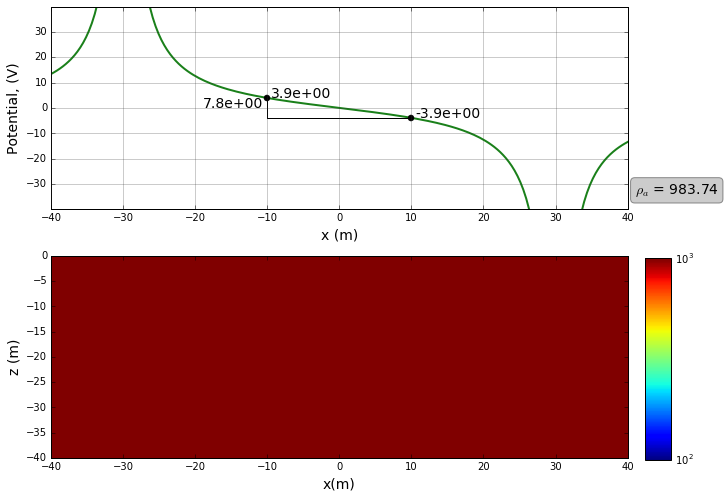

In [24]:
plot_Layer_Potentials_interact = lambda rho1,rho2,h,A,B,M,N,Plot: plot_Layer_Potentials(rho1,rho2,h,A,B,M,N,Plot)
app = interact(plot_Layer_Potentials_interact,
            rho1 = FloatSlider(min=rhomin,max=rhomax,step=10.,value = rhomin),
            rho2 = FloatSlider(min=rhomin,max=rhomax,step=10.,value = rhomax),
            h = FloatSlider(min=0.,max=40.,step=1.,value=0.),
            A = FloatSlider(min=-40.,max=40.,step=1.,value=-30.),
            B = FloatSlider(min=-40.,max=40.,step=1.,value=30.),
            M = FloatSlider(min=-40.,max=40.,step=1.,value=-10.),
            N = FloatSlider(min=-40.,max=40.,step=1.,value=10.),
            Plot = ToggleButtons(options =['model','potential','e','j'],value='model'),
            )